### Issues with QA lab

In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3, 4, 5, 6, 7"
import time
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from transformers import logging
logging.set_verbosity_error()

%matplotlib inline

import util
from models import RUBertForQA

2022-03-16 17:17:48.037673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64:/usr/local/cuda/lib64
2022-03-16 17:17:48.037702: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
model_name = "bert-base-uncased"

### Installed package versions   
torch==1.10.0  
transformers==4.12.5
  
Python version  
Python 3.9.7

### Issue 1  

**Solved**  
When I change number of attention heads using parameter `num_attention_heads`, total number of trainable parameters doesn't change

Function `count_parameters` is taken from https://github.com/girafe-ai/natural-language-processing/blob/master/homeworks/lab01_nlp/lab1_02_nlp_part2_nmt.ipynb

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for i in [4,6,8,12]:
    bert = AutoModel.from_pretrained(model_name, num_attention_heads = i)
    print(f'Number of parameters for {i} heads: {count_parameters(bert)}')

Number of parameters for 4 heads: 109482240
Number of parameters for 6 heads: 109482240
Number of parameters for 8 heads: 109482240
Number of parameters for 12 heads: 109482240


**Explanation**  
  
Bert uses one set of matrices Q, V and K for all heads. Number of columns in matrices doesn't depend on `num_attention_heads`. Each 64 columns are in charge of a particular head. Thus changing the number of heads does not affect the number of parameters, because matrices size doesn't change.  
Details: https://towardsdatascience.com/deep-dive-into-the-code-of-bert-model-9f618472353e  
https://github.com/google-research/bert/issues/656

In [4]:
bert = AutoModel.from_pretrained(model_name, num_attention_heads = 1, num_hidden_layers = 1)
display(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

### Issue 2  

When I use multiple GPUs, I can't choose number of them and BATCH_SIZE arbitrarily.  
For example, let's use 6 GPUs and BATCH_SIZE = 16 with training set with 45328 samples.


In [5]:
# create train data  in appropriate formats from SberQuad files
train_contexts, train_questions, train_answers = util.read_squad('data/train-v1.1.json')

# add index of end position of the answer
util.add_end_idx(train_answers, train_contexts)

#get tokenized encodings
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_encodings = (tokenizer(list(train_contexts.values()), list(train_questions.values()), 
                             truncation=True, padding=True, max_length = max_length, return_tensors = 'pt'))

# enrich train encodings: add fields 'start_positions', 'end_positions' and 'ids':
# 'start_positions' - token number where the answer starts, 'end_positions' - where the answer ends
# 'ids' - id of the question in SberQuad dataset
train_truncated_idxs = util.add_token_positions(train_encodings, train_answers, max_length)

#create Dataset object from encodings
train_dataset = util.SquadDataset(train_encodings)

# define the model
pad_token = tokenizer.pad_token
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)

BATCH_SIZE = 16
DROPOUT = 0.5
LEARNING_RATE = 5e-5
bert = AutoModel.from_pretrained(model_name, num_hidden_layers = 1, num_attention_heads = 1)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = RUBertForQA(bert, DROPOUT)
model = torch.nn.DataParallel(model, device_ids=[0,1,2,3,4,5]).cuda()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.NLLLoss(ignore_index = pad_token_idx)
criterion = criterion.cuda()

In [7]:
print('samples in training set:', len(train_dataset))

samples in training set: 45328


Get the error:

In [6]:
N_EPOCHS = 1
train_history = []
valid_history = []
for epoch in range(N_EPOCHS):
        start_time = time.time()
        train_loss = util.train(model, train_loader, optimizer, criterion,
                           train_history, valid_history)
        end_time = time.time()
        epoch_mins, epoch_secs = util.epoch_time(start_time, end_time)
        train_history.append(train_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')

0it [00:17, ?it/s]


RuntimeError: Expected all input tensors to have the same number of dimensions, but tensor at index 5has 1 dimensions, (expected 2)

But if we do exactly the same but on 5 GPUs, it works

In [8]:
bert2 = AutoModel.from_pretrained(model_name, num_hidden_layers = 9)
model2 = RUBertForQA(bert2, DROPOUT)
model2 = torch.nn.DataParallel(model2, device_ids=[0, 1, 2, 3, 4]).cuda()
optimizer2 = optim.Adam(model2.parameters(), lr = LEARNING_RATE)

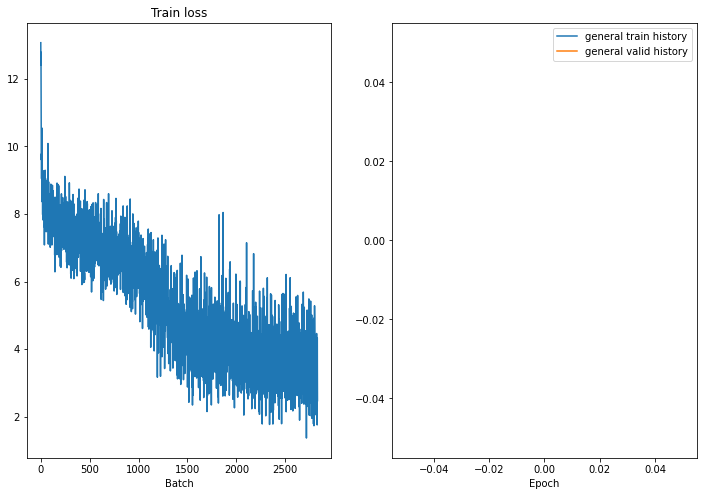

2833it [14:37,  3.23it/s]

Epoch: 01 | Time: 14m 37s
	Train Loss: 5.333


In [9]:
for epoch in range(N_EPOCHS):
        start_time = time.time()
        train_loss = util.train(model2, train_loader, optimizer2, criterion,
                           train_history, valid_history)
        end_time = time.time()
        epoch_mins, epoch_secs = util.epoch_time(start_time, end_time)
        train_history.append(train_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')